In [41]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (10,7)})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


15 30 500


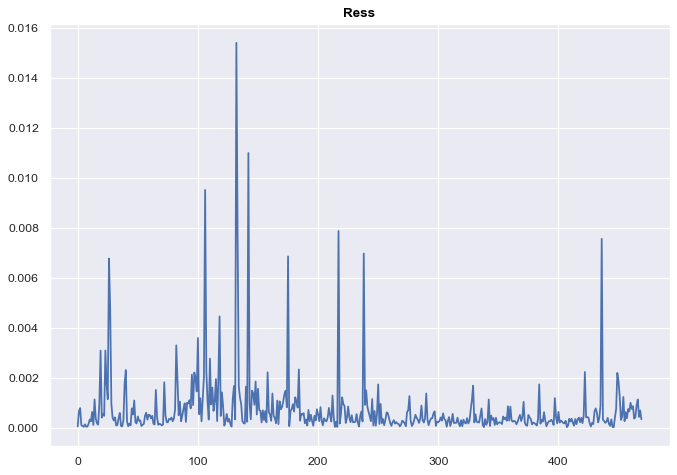

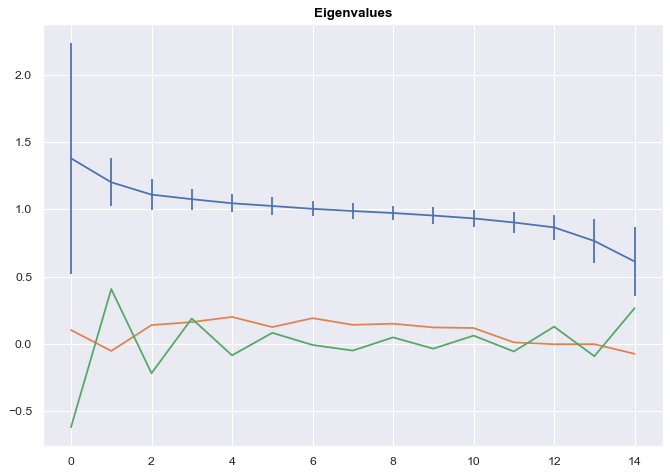

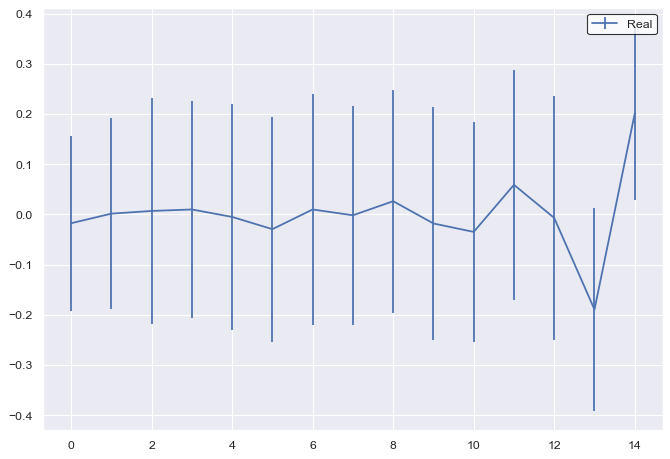

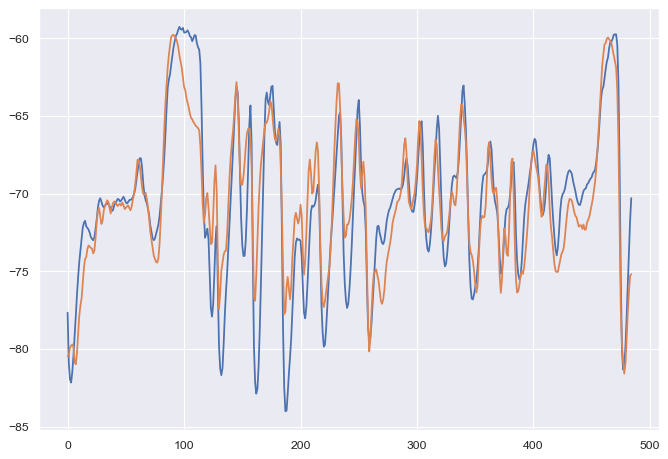

ERR 6.4218526986828355


In [43]:
dt_ms = 2.0
lag_ms = 30
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)
Xhan = build_hankel(X_series, dim)
X0 = Xhan[:, :-1]
Xp = Xhan[:, 1:]

N = len(X_series)
window = int(dim * 2)
beta = 0.000001
thetas, ws, ress = [], [], []
print(dim, window, len(X_series))
for i in range(window, N, 1):

    sl = slice(i-window, i)
    Xhan = build_hankel(X_series[sl], dim)
    X0w = Xhan[:, :-1]
    Xpw = Xhan[:, 1:]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
    reg_dim = dim + 1

    # matrix for regularization
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    # a = scipy.linalg.lstsq(X01.T, Xp1)[0]
    a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a
    w, vl = scipy.linalg.eig(A, left=True, right=False)

    c_col = np.zeros((A.shape[1],1)) 
    c_col[-1] =c
    A = np.concatenate((A, c_col), axis=1)
    res = np.linalg.norm(Xpw-(A @ X01))

    sortorder = np.argsort(np.abs(w))
    w = w[sortorder][::-1]
    theta = vl[:, sortorder][:, -1]
    theta *= np.sign(theta[-1])

    weight = res
    ress.append(res)
    thetas.append(theta)
    ws.append(w)

ws = np.array(ws)
thetas = np.array(thetas)
ress = np.array(ress)
zero_theta = np.zeros_like(thetas[0])
# ress01 = 1-normalize_01(ress)
# thetas = np.multiply(thetas, ress01[:, np.newaxis])
# ws = np.multiply(ws, ress01[:, np.newaxis])
# thetas[ress > 0.001] = np.zeros_like(thetas[0])
plt.plot(ress)
plt.title('Ress')
plt.show()

# for i,t in enumerate(thetas[::10]):
#     plt.plot(t.real+i)
#     plt.show()

d = np.arange(0, len(ws[0]))
plt.errorbar(d, np.mean(np.abs(ws), axis=0), np.std(np.abs(ws), axis=0))
plt.plot(np.mean(ws.real, axis=0))
plt.plot(np.mean(ws.imag, axis=0))
plt.title('Eigenvalues')
plt.show()


theta = np.mean(thetas, axis=0)
d = np.arange(0, len(theta))
t_std_real = np.std(thetas.real, axis=0)
t_std_imag = np.std(thetas.imag, axis=0)

plt.errorbar(d, theta.real, t_std_real, label='Real')
# plt.errorbar(d, theta.imag, t_std_imag, label='Imag')
plt.legend()
plt.show()

Xhan = build_hankel(X_series, dim)
P_series = theta.real @ Xhan
Y_series = Y_series[dim:]
P_series = solve_scale_shift(P_series, Y_series)
plt.plot(Y_series)
plt.plot(P_series)
plt.show()
print('ERR', mean_square_error(P_series, Y_series))